In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [4]:
# BOTS = ['NNBot', 'NNBotWithObservePropose', 'ObserveBot', 'RandomBot', 'RandomBotUV', 'SimpleBot', 'SimpleStatsBot', 'CFRBot_1000000', 'CFRBot_2000000', 'CFRBot_3000000', 'CFRBot_4000000']
# DATA_BY_BOT = {}
# for bot in BOTS:
#     print "Loading", bot
#     with gzip.open('human/{}.msg.gz'.format(bot), 'r') as f:
#         DATA_BY_BOT[bot] = pd.read_msgpack(f)
    
# with gzip.open('human/actions.msg.gz', 'r') as f:
#     HUMAN_ACTIONS = pd.read_msgpack(f)

DATA_BY_BOT = {}
for directory in glob.glob('human/*'):
    bot = directory[6:]
    print "Loading", bot
    dataframes = []
    for filename in glob.glob(directory + "/*.msg.gz"):
        with gzip.open(filename, 'r') as f:
            dataframes.append(pd.read_msgpack(f))
    result = pd.concat(dataframes)
    result.reset_index(drop=True, inplace=True)
    DATA_BY_BOT[bot] = result

def load_bot(name):
    result = []
    for filename in glob.glob('merlin/' + name + '/*'):
        with gzip.open(filename, 'r') as f:
            result.append(pd.read_msgpack(f))
    return pd.concat(result)


Loading cfrbot3
Loading deeprole_500_250
Loading observebot
Loading simplestatsbot
Loading deeprole_2000_1000
Loading cfrbot6
Loading deeprole_100_50
Loading randombot
Loading randombotuv


In [33]:
GAMES_PLAYED_BY_PLAYER = DATA_BY_BOT['randombot'].groupby(['game', 'player']).size().reset_index()[['game', 'player']]
GAMES_PLAYED_BY_PLAYER = GAMES_PLAYED_BY_PLAYER.player.value_counts().reset_index()

GAMES_PLAYED_BY_PLAYER

,index,player
0,27,74
1,26,73
2,25,70
3,3405,57
4,2948,54
5,10356,52
6,2462,51
7,10352,51
8,1768,48
9,10354,47


In [42]:
GAMES_PLAYED_BY_PLAYER = DATA_BY_BOT['randombot'].groupby(['game', 'player']).size().reset_index()[['game', 'player']]
GAMES_PLAYED_BY_PLAYER = GAMES_PLAYED_BY_PLAYER.player.value_counts().reset_index()

def values_for_cutoff(df, cutoff):
    players_df = GAMES_PLAYED_BY_PLAYER[:cutoff]
    players = players_df['index']
    
    df = df[df.merlin.isin(players)]
    
    return {
        'top_k_players': cutoff,
        'n': len(df),
#         'experience': players_df.player.sum(),
        'bot_correct_prob': df.bot_correct_prob.mean(),
        'human_correct_prob': (df.correct_guess == df.human_guess).mean(),
    }

deep = load_bot('deeprole_100_50')

results = [values_for_cutoff(deep, c) for c in [5, 10, 50, 100, 500, 1000, 4000]]

pd.DataFrame(results)

,bot_correct_prob,human_correct_prob,n,top_k_players
0,0.382444,0.375000,40,5
1,0.427674,0.389610,77,10
2,0.412937,0.389381,226,50
3,0.410439,0.397727,352,100
4,0.396575,0.442602,784,500
5,0.397751,0.435923,991,1000
6,0.397032,0.449670,1212,4000


In [6]:
def get_cost(df, tremble_prob, cost_func):
    propose_moves = df[df.type == 'propose']
    vote_moves = df[df.type == 'vote']
    mission_moves = df[(df.type == 'mission') & (df.role.isin(['minion', 'assassin']))]
    merlin_moves = df[df.type == 'merlin']
    
    propose_prob = (1.0 - tremble_prob) * propose_moves.prob + tremble_prob * (1.0 / 10)
    propose_nll = cost_func(propose_prob).sum()
    
    vote_prob = (1.0 - tremble_prob) * vote_moves.prob + tremble_prob * (1.0 / 2)
    vote_nll = cost_func(propose_prob).sum()
    
    mission_prob = (1.0 - tremble_prob) * mission_moves.prob + tremble_prob * (1.0 / 2)
    mission_nll = cost_func(propose_prob).sum()
    
    merlin_prob = (1.0 - tremble_prob) * merlin_moves.prob + tremble_prob * (1.0 / 5)
    merlin_nll = cost_func(propose_prob).sum()
    
    return propose_nll + vote_nll + mission_nll + merlin_nll, propose_nll, vote_nll, mission_nll, merlin_nll

def nll_cost(probs):
    return -np.log(probs)

def emd_cost(probs):
    return 1.0 - probs

def exp_cost(exponent):
    def cost(probs):
        return (1.0 - probs) ** exponent
    return cost

def get_dataframe(tremble, cost_func, fil=lambda df: df):
    data = []
    for bot in DATA_BY_BOT.keys():
        filtered_data = fil(DATA_BY_BOT[bot])
        t, p, v, m, r = get_cost(filtered_data, tremble, cost_func)
        data.append({
            'bot': bot,
            'tremble': tremble,
            'total': t,
            'propose': p,
            'vote': v,
            'mission': m,
            'merlin': r
        })
    return pd.DataFrame(data, columns=['bot', 'tremble', 'total', 'propose', 'vote', 'mission', 'merlin'])

In [7]:
def find_minimum(func, start, end, step):
    m = (None, float('inf'))
    for i in np.arange(start, end, step):
        v = func(i)
        if v < m[1]:
            m = (i, v)
    return m

def bot_nll(bot):
    def nll(tremble):
        return get_nll(DATA_BY_BOT[bot], tremble)[4]
    return nll

print find_minimum(bot_nll('simplestatsbot'), 0.01, 1.0, 0.01)
print find_minimum(bot_nll('observebot'), 0.01, 1.0, 0.01)
print find_minimum(bot_nll('deeprole_100_50'), 0.01, 1.0, 0.01)
print find_minimum(bot_nll('deeprole_500_250'), 0.01, 1.0, 0.01)
print find_minimum(bot_nll('deeprole_2000_1000'), 0.01, 1.0, 0.01)

NameError: global name 'get_nll' is not defined

In [8]:
TOP100_PLAYERS = DATA_BY_BOT['randombot'].player.value_counts()[:100].reset_index()['index']
get_dataframe(0.01, exp_cost(1/2.0), fil=lambda df: df[df.player.isin(TOP100_PLAYERS)]).sort_values('total')

list(TOP100_PLAYERS)

[27,
 25,
 26,
 2462,
 3405,
 3376,
 2948,
 10356,
 3710,
 1768,
 10352,
 10354,
 1524,
 2713,
 31,
 3792,
 3031,
 2540,
 1523,
 10374,
 3379,
 11431,
 1791,
 2741,
 2137,
 3252,
 2134,
 18,
 2782,
 30,
 2227,
 122,
 2419,
 2129,
 3391,
 29,
 12843,
 2004,
 2761,
 3255,
 12866,
 1979,
 10637,
 4891,
 1978,
 10635,
 4929,
 1980,
 2005,
 2228,
 12865,
 2708,
 12864,
 12863,
 9328,
 4161,
 3825,
 2188,
 3044,
 2186,
 3228,
 1733,
 9820,
 10143,
 8444,
 9326,
 3086,
 2190,
 8648,
 8650,
 3611,
 3994,
 1550,
 2175,
 1466,
 1465,
 3658,
 8644,
 3316,
 1742,
 291,
 12759,
 2013,
 2769,
 1734,
 6059,
 2183,
 17435,
 8652,
 3217,
 8486,
 3234,
 2625,
 3351,
 11,
 5301,
 5655,
 13157,
 13166,
 11678]

In [83]:
def get_prob(df, tremble_prob):
    propose_moves = df[df.type == 'propose']
    vote_moves = df[df.type == 'vote']
    mission_moves = df[(df.type == 'mission') & (df.role.isin(['minion', 'assassin']))]
    merlin_moves = df[df.type == 'merlin']
    
    propose_prob = (1.0 - tremble_prob) * propose_moves.prob + tremble_prob * (1.0 / 10)
    
    vote_prob = (1.0 - tremble_prob) * vote_moves.prob + tremble_prob * (1.0 / 2)
    
    mission_prob = (1.0 - tremble_prob) * mission_moves.prob + tremble_prob * (1.0 / 2)
    
    merlin_prob = (1.0 - tremble_prob) * merlin_moves.prob + tremble_prob * (1.0 / 5)
    
    total_prob = (
        propose_prob.sum() + vote_prob.sum() + mission_prob.sum() + merlin_prob.sum()
    ) / (len(propose_prob) + len(vote_prob) + len(mission_prob) + len(merlin_prob))
    
    return total_prob, propose_prob.mean(), vote_prob.mean(), mission_prob.mean(), merlin_prob.mean()


def get_dataframe_2(tremble, fil=lambda df: df):
    data = []
    for bot in DATA_BY_BOT.keys():
        filtered_data = fil(DATA_BY_BOT[bot])
        t, p, v, m, r = get_prob(filtered_data, tremble)
        data.append({
            'bot': bot,
            'tremble': tremble,
            'total': t,
            'propose': p,
            'vote': v,
            'mission': m,
            'merlin': r
        })
    return pd.DataFrame(data, columns=['bot', 'tremble', 'total', 'propose', 'vote', 'mission', 'merlin'])

In [100]:
TOP100_PLAYERS = DATA_BY_BOT['randombot'].player.value_counts()[:].reset_index()['index']
result = get_dataframe_2(0.0, fil=lambda df: df[df.player.isin(TOP100_PLAYERS)])

result[['bot', 'merlin']].sort_values('merlin', ascending=False)

,bot,merlin
8,deeprole_100_50,0.389112
6,deeprole_500_250,0.388969
5,deeprole_2000_1000,0.386691
0,simplestatsbot,0.333333
7,cfrbot6,0.315123
4,cfrbot3,0.313630
1,observebot,0.200000
2,randombotuv,0.200000
3,randombot,0.200000


In [102]:
def grouped_barplot(plot_title, series_titles, group_titles, basis, *serieses):
    plt.figure(figsize=(16,8))
    # set width of bar
    COLORS = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3']
    barWidth = 1.0/(1 + len(serieses))

    # set height of bar
    bars1 = serieses[0]

    # Set position of bar on X axis
    positions = [ np.arange(len(bars1)) ]
    for _ in range(len(serieses) - 1):
        positions.append([x + barWidth for x in positions[-1] ])

    for i, (title, pos, series) in enumerate(zip(series_titles, positions, serieses)):
        plt.bar(pos, series, color=COLORS[i], width=barWidth, edgecolor='white', label=title)

    if basis is not None:
        plt.axhline(basis, color="gray")
        
    # Add xticks on the middle of the group bars
    plt.xlabel('group', fontweight='bold')
    plt.xticks([r + barWidth*(len(serieses) / 2.0 - 0.5) for r in range(len(bars1))], group_titles)

    # Create legend & Show graphic
    plt.title(plot_title)
    plt.legend()
    plt.show()

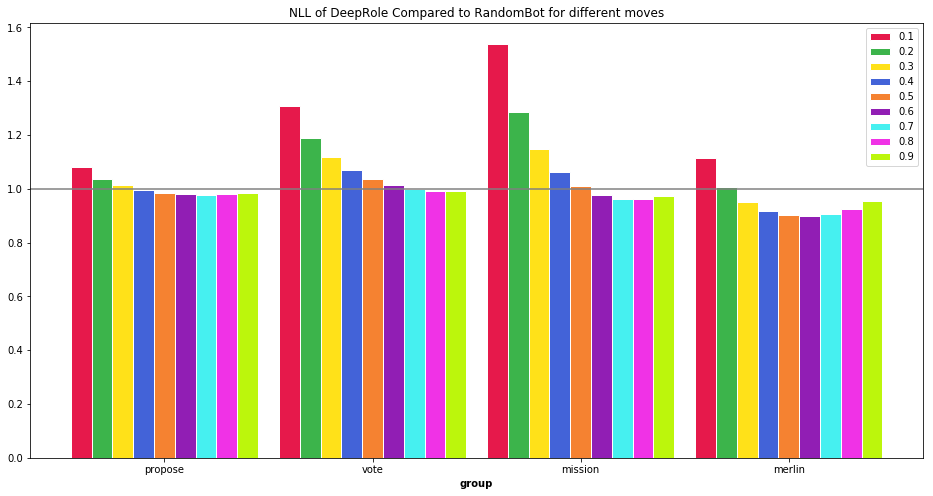

In [117]:
plot_title = "NLL of DeepRole Compared to RandomBot for different moves"
trembles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

rand_data = get_nll(DATA_BY_BOT['randombot'], 0.0)

other_data = np.array([get_nll(DATA_BY_BOT['deeprole_100_50'], tremble) for tremble in trembles])

other_data /= rand_data

other_data = other_data[:, 1:]

move_types = ['propose', 'vote', 'mission', 'merlin']

grouped_barplot(plot_title, trembles, move_types, 1.0, *list(other_data))

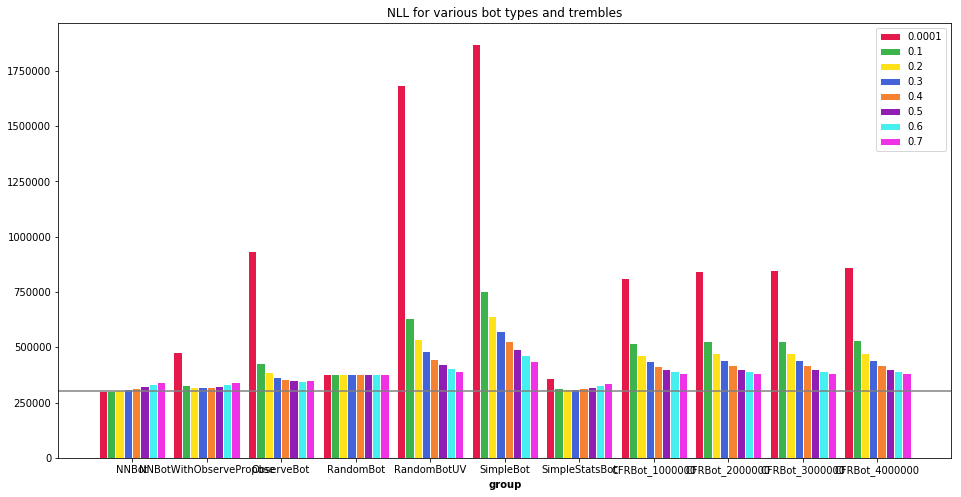

In [5]:
plot_title = "NLL for various bot types and trembles"
trembles = [0.0001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
bots = BOTS #["RandomBot", "RandomBotUV", "SimpleBot", "ObserveBot", "SimpleStatsBot", "NNBot", "NNBotWithObservePropose"]
BOT_DATA = [ DATA_BY_BOT[bot] for bot in bots ]
serieses = [ [ data[data.trembling_hand_prob == p].nll.sum() for data in BOT_DATA] for p in trembles ]
grouped_barplot(plot_title, trembles, bots, serieses[0][0], *serieses)

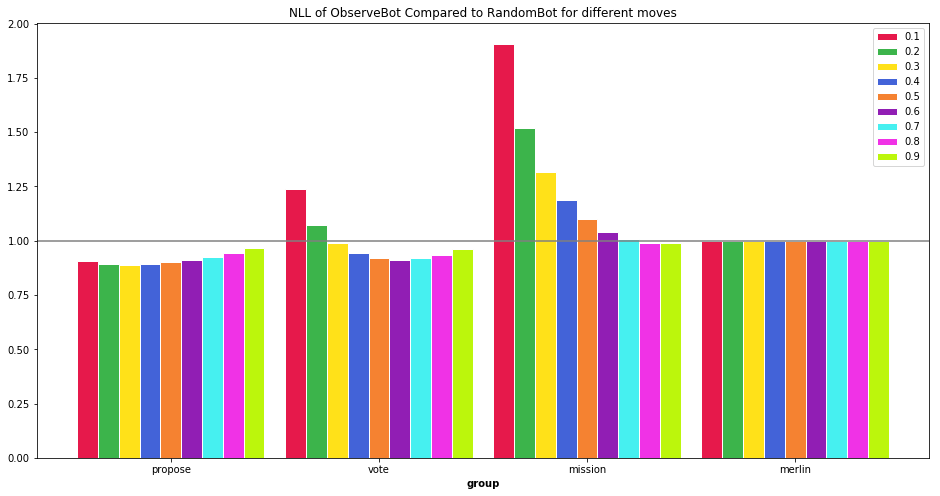

In [6]:
OB_DATA = DATA_BY_BOT['ObserveBot']
RAND_DATA = DATA_BY_BOT['RandomBot']
plot_title = "NLL of ObserveBot Compared to RandomBot for different moves"
trembles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
move_types = ["propose", "vote", "mission", "merlin"]
rand_perf = {
    typ: RAND_DATA[(RAND_DATA.type == typ) & (RAND_DATA.trembling_hand_prob == 0.1)].nll.sum()
    for typ in move_types
}
serieses = [
    [
        OB_DATA[(OB_DATA.type == typ) & (OB_DATA.trembling_hand_prob == p)].nll.sum()/rand_perf[typ]
        for typ in move_types
    ]
    for p in trembles
]
grouped_barplot(plot_title, trembles, move_types, 1.0, *serieses)

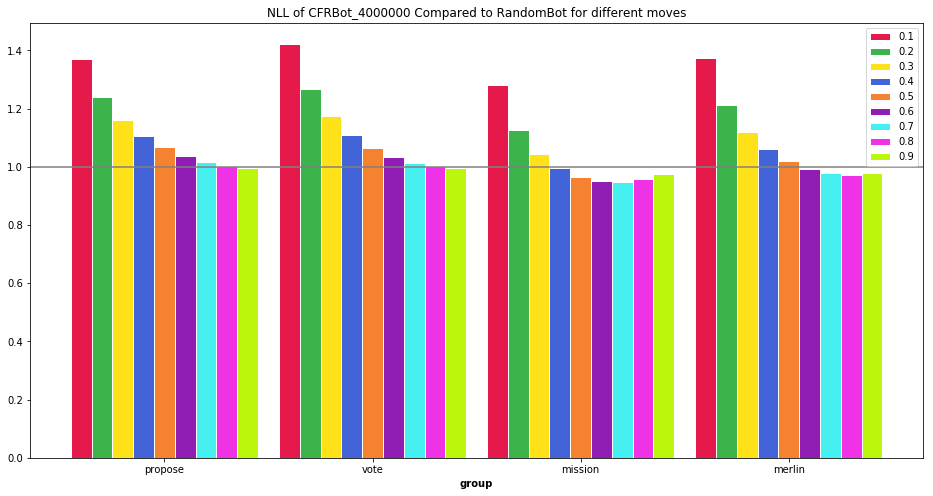

In [7]:
cfr_bot = 'CFRBot_4000000'
CFR_DATA = DATA_BY_BOT[cfr_bot]
RAND_DATA = DATA_BY_BOT['RandomBot']
plot_title = "NLL of {} Compared to RandomBot for different moves".format(cfr_bot)
trembles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
move_types = ["propose", "vote", "mission", "merlin"]
rand_perf = {
    typ: RAND_DATA[(RAND_DATA.type == typ) & (RAND_DATA.trembling_hand_prob == 0.1)].nll.sum()
    for typ in move_types
}
serieses = [
    [
        CFR_DATA[(CFR_DATA.type == typ) & (CFR_DATA.trembling_hand_prob == p)].nll.sum()/rand_perf[typ]
        for typ in move_types
    ]
    for p in trembles
]
grouped_barplot(plot_title, trembles, move_types, 1.0, *serieses)

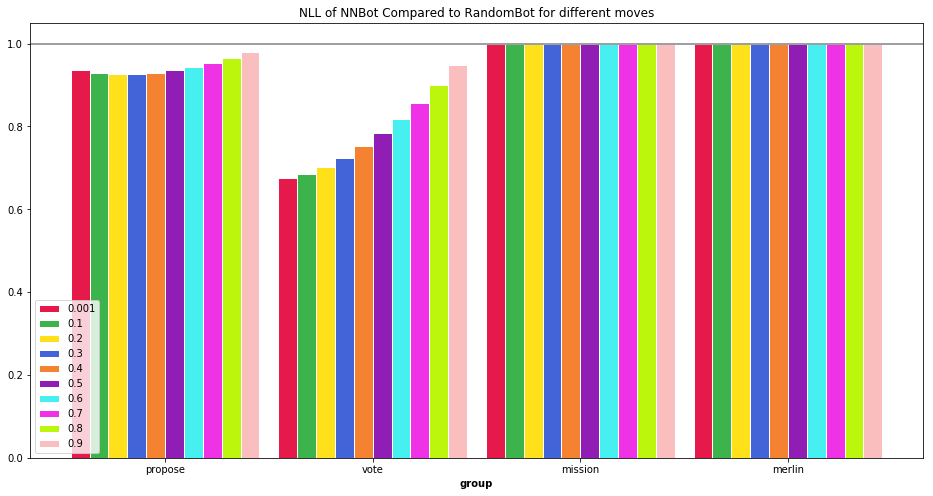

In [8]:
NN_DATA = DATA_BY_BOT['NNBot']
RAND_DATA = DATA_BY_BOT['RandomBot']
plot_title = "NLL of NNBot Compared to RandomBot for different moves"
trembles = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
move_types = ["propose", "vote", "mission", "merlin"]
rand_perf = {
    typ: RAND_DATA[(RAND_DATA.type == typ) & (RAND_DATA.trembling_hand_prob == 0.1)].nll.sum()
    for typ in move_types
}
serieses = [
    [
        NN_DATA[(NN_DATA.type == typ) & (NN_DATA.trembling_hand_prob == p)].nll.sum()/rand_perf[typ]
        for typ in move_types
    ]
    for p in trembles
]
grouped_barplot(plot_title, trembles, move_types, 1.0, *serieses)

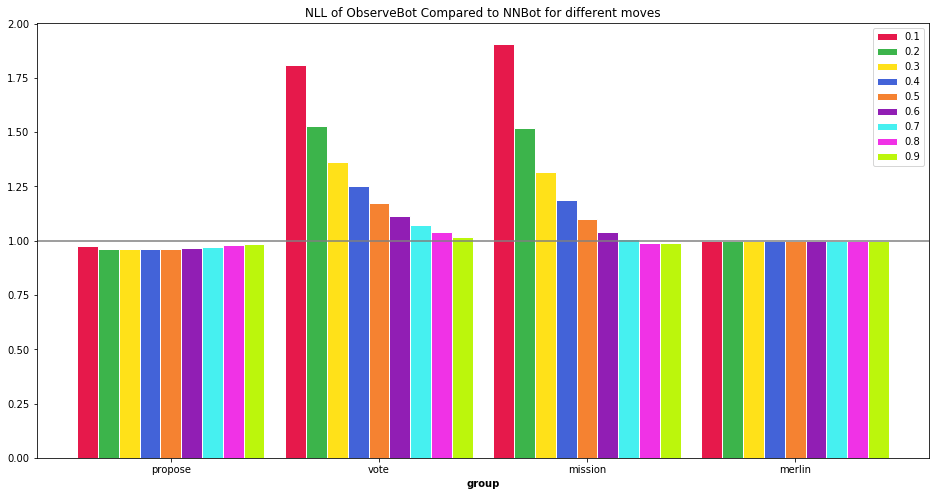

In [9]:
plot_title = "NLL of ObserveBot Compared to NNBot for different moves"
trembles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
move_types = ["propose", "vote", "mission", "merlin"]

serieses = [
    [
        (
            OB_DATA[(OB_DATA.type == typ) & (OB_DATA.trembling_hand_prob == p)].nll.sum() /
            NN_DATA[(NN_DATA.type == typ) & (NN_DATA.trembling_hand_prob == p)].nll.sum()
        )
        for typ in move_types
    ]
    for p in trembles
]
grouped_barplot(plot_title, trembles, move_types, 1.0, *serieses)

/Users/jserrino/.virtualenvs/battlefield/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


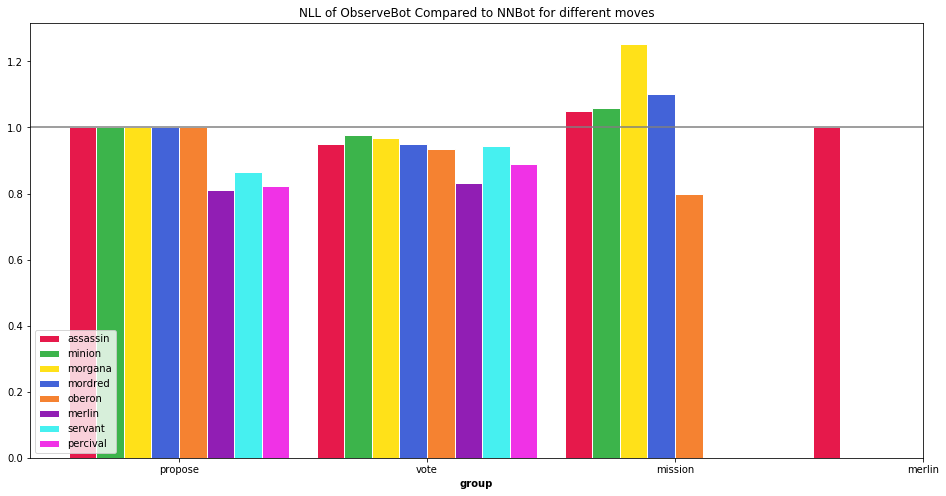

In [10]:
plot_title = "NLL of ObserveBot Compared to NNBot for different moves"
roles = ['assassin', 'minion', 'morgana', 'mordred', 'oberon', 'merlin', 'servant', 'percival']
move_types = ["propose", "vote", "mission", "merlin"]

serieses = [
    [
        (
            OB_DATA[(OB_DATA.role == role) & (OB_DATA.type == typ) & (OB_DATA.trembling_hand_prob == 0.5)].nll.sum() /
            RAND_DATA[(RAND_DATA.role == role) & (RAND_DATA.type == typ) & (RAND_DATA.trembling_hand_prob == 0.5)].nll.sum()
        )
        for typ in move_types
    ]
    for role in roles
]
grouped_barplot(plot_title, roles, move_types, 1.0, *serieses)

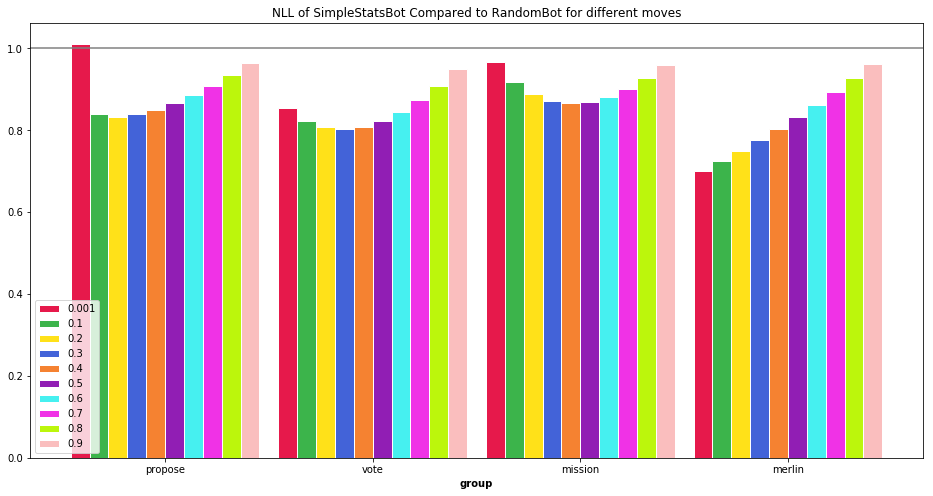

In [11]:
SSB_DATA = DATA_BY_BOT['SimpleStatsBot']
RAND_DATA = DATA_BY_BOT['RandomBot']
plot_title = "NLL of SimpleStatsBot Compared to RandomBot for different moves"
trembles = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
move_types = ["propose", "vote", "mission", "merlin"]
rand_perf = {
    typ: RAND_DATA[(RAND_DATA.type == typ) & (RAND_DATA.trembling_hand_prob == 0.1)].nll.sum()
    for typ in move_types
}
serieses = [
    [
        SSB_DATA[(SSB_DATA.type == typ) & (SSB_DATA.trembling_hand_prob == p)].nll.sum()/rand_perf[typ]
        for typ in move_types
    ]
    for p in trembles
]
grouped_barplot(plot_title, trembles, move_types, 1.0, *serieses)

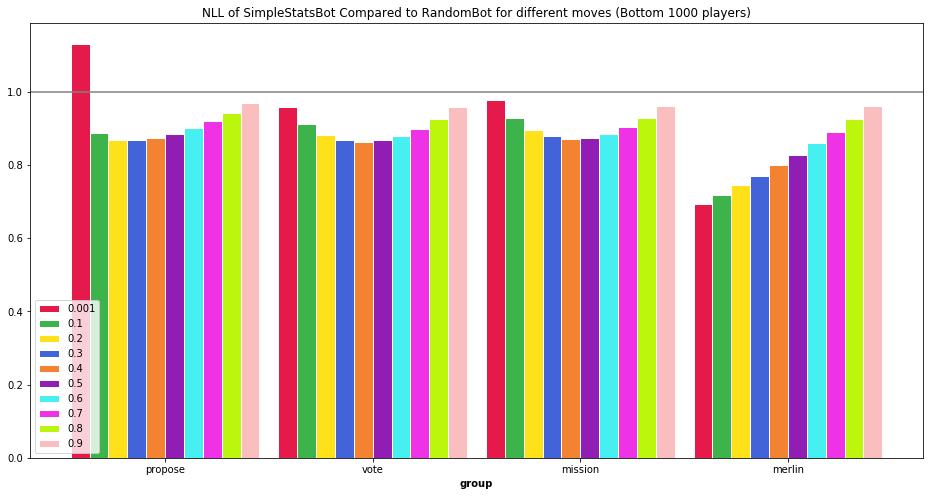

In [12]:
TOP100_PLAYERS = RAND_DATA.player.value_counts()[1000:].reset_index()['index']
SSB_TOP100_DATA = SSB_DATA[SSB_DATA.player.isin(TOP100_PLAYERS)]
RAND_TOP100_DATA = RAND_DATA[RAND_DATA.player.isin(TOP100_PLAYERS)]
plot_title = "NLL of SimpleStatsBot Compared to RandomBot for different moves (Bottom 1000 players)"
trembles = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
move_types = ["propose", "vote", "mission", "merlin"]
rand_perf = {
    typ: RAND_TOP100_DATA[(RAND_TOP100_DATA.type == typ) & (RAND_TOP100_DATA.trembling_hand_prob == 0.1)].nll.sum()
    for typ in move_types
}
serieses = [
    [
        SSB_TOP100_DATA[(SSB_TOP100_DATA.type == typ) & (SSB_TOP100_DATA.trembling_hand_prob == p)].nll.sum()/rand_perf[typ]
        for typ in move_types
    ]
    for p in trembles
]
grouped_barplot(plot_title, trembles, move_types, 1.0, *serieses)

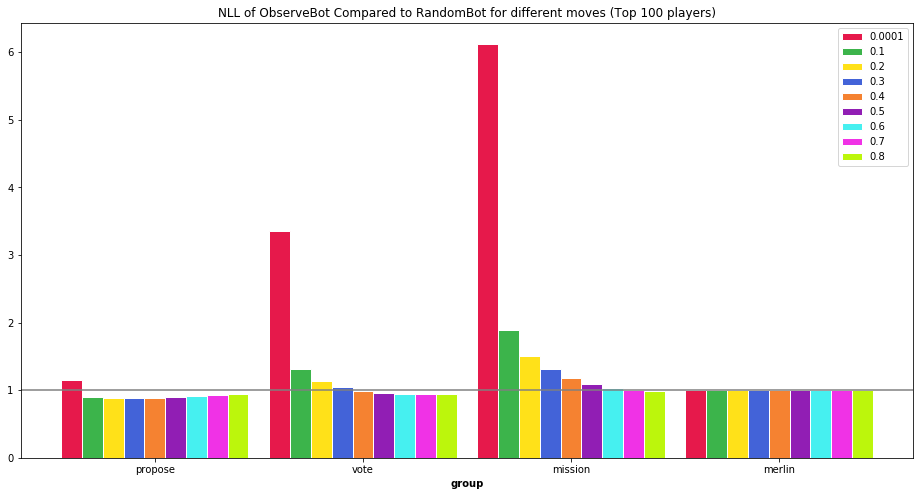

In [13]:
OB_TOP100_DATA = OB_DATA[OB_DATA.player.isin(TOP100_PLAYERS)]
plot_title = "NLL of ObserveBot Compared to RandomBot for different moves (Top 100 players)"
trembles = [0.0001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
move_types = ["propose", "vote", "mission", "merlin"]
rand_perf = {
    typ: RAND_TOP100_DATA[(RAND_TOP100_DATA.type == typ) & (RAND_TOP100_DATA.trembling_hand_prob == 0.1)].nll.sum()
    for typ in move_types
}
serieses = [
    [
        OB_TOP100_DATA[(OB_TOP100_DATA.type == typ) & (OB_TOP100_DATA.trembling_hand_prob == p)].nll.sum()/rand_perf[typ]
        for typ in move_types
    ]
    for p in trembles
]
grouped_barplot(plot_title, trembles, move_types, 1.0, *serieses)

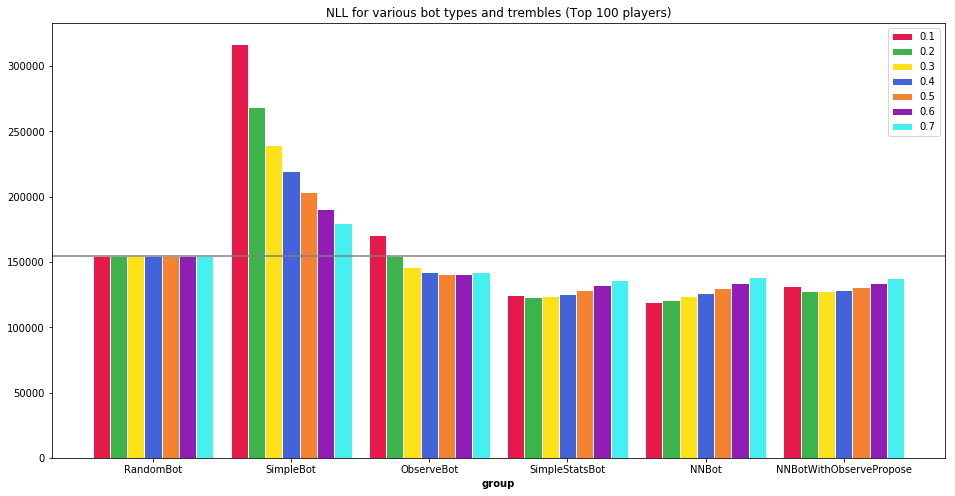

In [14]:
TOP100_PLAYERS = RAND_DATA.player.value_counts()[:100].reset_index()['index']
plot_title = "NLL for various bot types and trembles (Top 100 players)"
trembles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
bots = ["RandomBot", "SimpleBot", "ObserveBot", "SimpleStatsBot", "NNBot", "NNBotWithObservePropose"]
BOT_DATA = [ DATA_BY_BOT[bot] for bot in bots ]
BOT_DATA = [ bot[bot.player.isin(TOP100_PLAYERS)] for bot in BOT_DATA ]
serieses = [ [ data[data.trembling_hand_prob == p].nll.sum() for data in BOT_DATA] for p in trembles ]
grouped_barplot(plot_title, trembles, bots, serieses[0][0], *serieses)

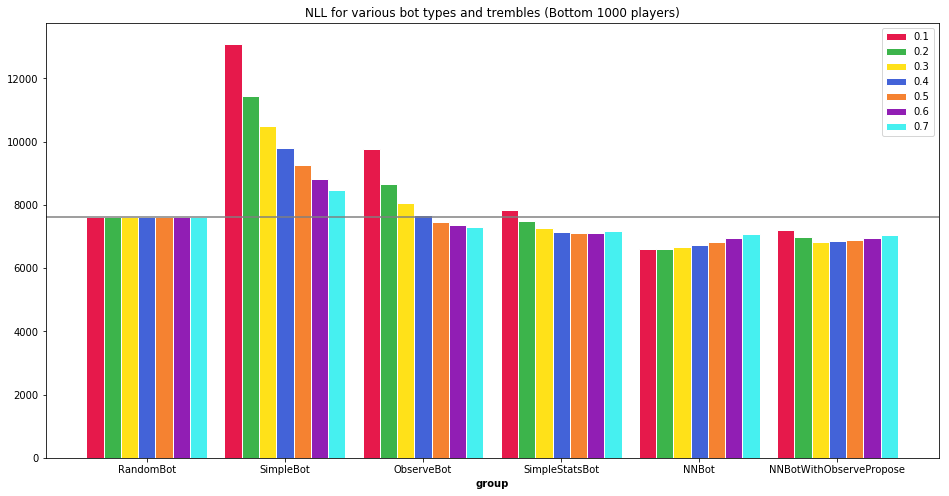

In [15]:
BOTTOM1000_PLAYERS = RAND_DATA.player.value_counts()[-1000:].reset_index()['index']
plot_title = "NLL for various bot types and trembles (Bottom 1000 players)"
trembles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
bots = ["RandomBot", "SimpleBot", "ObserveBot", "SimpleStatsBot", "NNBot", "NNBotWithObservePropose"]
BOT_DATA = [ DATA_BY_BOT[bot] for bot in bots ]
BOT_DATA = [ bot[bot.player.isin(BOTTOM1000_PLAYERS)] for bot in BOT_DATA ]
serieses = [ [ data[data.trembling_hand_prob == p].nll.sum() for data in BOT_DATA] for p in trembles ]
grouped_barplot(plot_title, trembles, bots, serieses[0][0], *serieses)

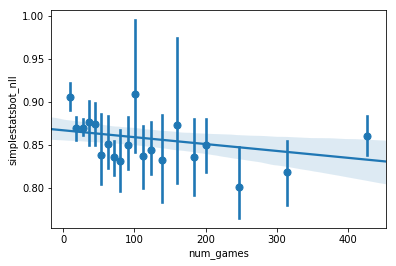

In [18]:
SSB_DATA = DATA_BY_BOT['SimpleStatsBot']
RAND_DATA = DATA_BY_BOT['RandomBot']
GAMES_PLAYED_BY_PLAYER = HUMAN_ACTIONS.groupby(['game', 'player']).size().reset_index()[['game', 'player']]
GAMES_PLAYED_BY_PLAYER = GAMES_PLAYED_BY_PLAYER.player.value_counts().reset_index()
PLAY_COUNTS = GAMES_PLAYED_BY_PLAYER.player.unique()

# if data is None:
data = []
for play_count in PLAY_COUNTS:
    player_with_play_count = GAMES_PLAYED_BY_PLAYER[GAMES_PLAYED_BY_PLAYER.player == play_count]['index']
    data.append({
        'num_games': play_count,
        'simplestatsbot_nll': (
            SSB_DATA[SSB_DATA.player.isin(player_with_play_count)].nll.sum() /
            RAND_DATA[RAND_DATA.player.isin(player_with_play_count)].nll.sum()
        )
    })

df = pd.DataFrame(data[10:])
sns.regplot(x='num_games', y='simplestatsbot_nll', data=df, x_bins=20)

In [23]:
def load_prediction_dataframe():
    dataframes = []
    for filename in glob.glob('predict_roles/*.msg.gz'):
        with gzip.open(filename, 'r') as f:
            dataframes.append(pd.read_msgpack(f))
    result = pd.concat(dataframes)
    result.bot = result.bot.astype('category')
    for i in range(5):
        result['role_{}'.format(i)] = result['role_{}'.format(i)].astype('category')
    result.reset_index(drop=True, inplace=True)
    return result

PREDICTION_DATAFRAME = load_prediction_dataframe()

In [35]:
PREDICTION_DATAFRAME[PREDICTION_DATAFRAME.bot == 'RandomBot'].nll.sum()

402412.67799926776

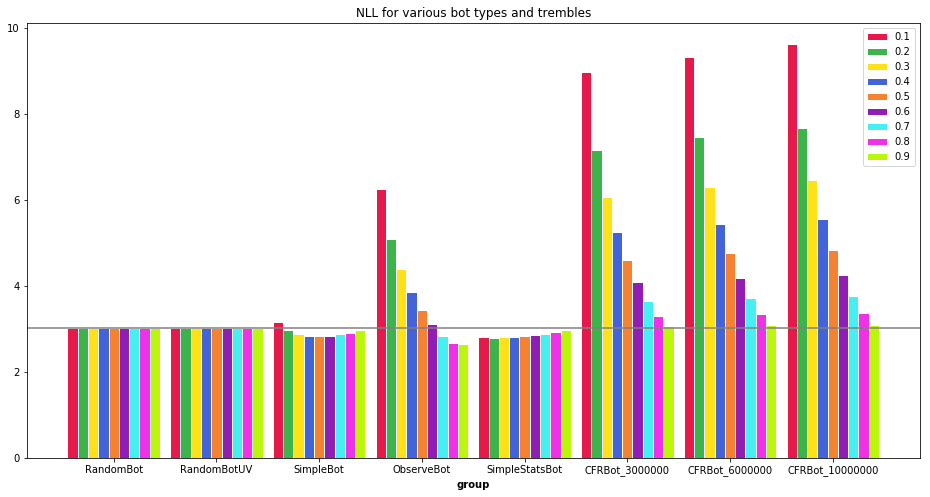

In [44]:
filtered = PREDICTION_DATAFRAME
for i in range(5):
    filtered = filtered[filtered['role_{}'.format(i)].isin(['merlin', 'servant', 'minion', 'assassin'])]

plot_title = "NLL for various bot types and trembles"
trembles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
bots = ["RandomBot", "RandomBotUV", "SimpleBot", "ObserveBot", "SimpleStatsBot", "CFRBot_3000000", "CFRBot_6000000", "CFRBot_10000000"]
BOT_DATA = [ filtered[filtered.bot == bot] for bot in bots ]
serieses = [ [ data[data.trembling_hand_prob == p].nll.mean() for data in BOT_DATA] for p in trembles ]
grouped_barplot(plot_title, trembles, bots, serieses[0][0], *serieses)